### Loading the Dataset and main pre-processing

In [301]:
import pandas as pd
from sklearn.model_selection import train_test_split


In [302]:
#reading the dataset from google drive folder
df=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dataset.csv")

In [303]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


In [305]:
object_cols=["f1","f2","f3","f4","f5","f6","f7"]
for col in object_cols:
  df[col]=pd.to_numeric(df[col],errors="coerce",downcast="float") #converting object cols to numeric cols

In [308]:
rows_with_nan=df[df.isna().any(axis=1)]

In [309]:
#removing nans
for idx, row in rows_with_nan.iterrows():
    for col in df:
        if pd.isna(row[col]):
            df.loc[idx,col] = df[col].median()

In [310]:
#removing outliers
numeric_cols=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR


    df.loc[(df[col] < lower_bound) | (df[col] > upper_bound),col] = df[col].median()

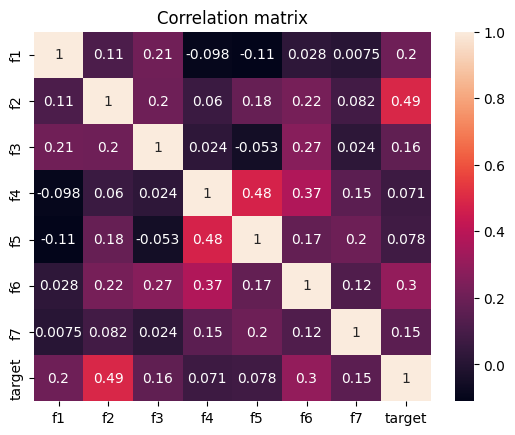

In [311]:
#correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix=df.corr()
sns.heatmap(corr_matrix,annot=True)
plt.title("Correlation matrix")
plt.show()

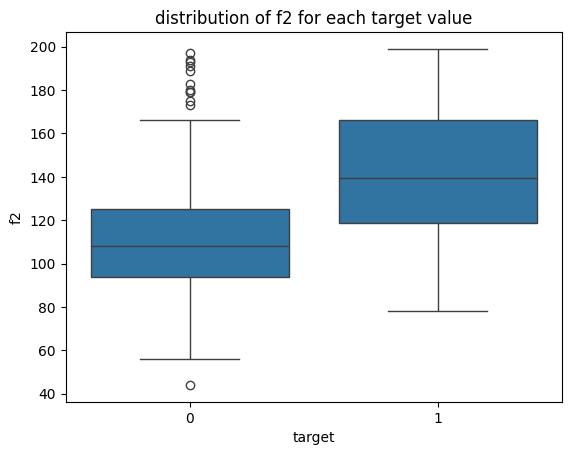

In [312]:
x=df['target']
y=df['f2']
sns.boxplot(x=x,y=y,data=df)
plt.title("distribution of f2 for each target value")
plt.show()

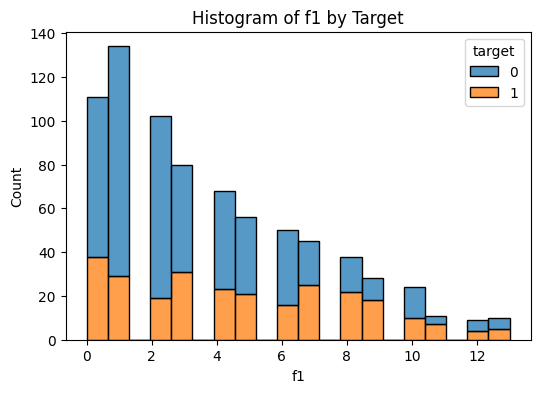

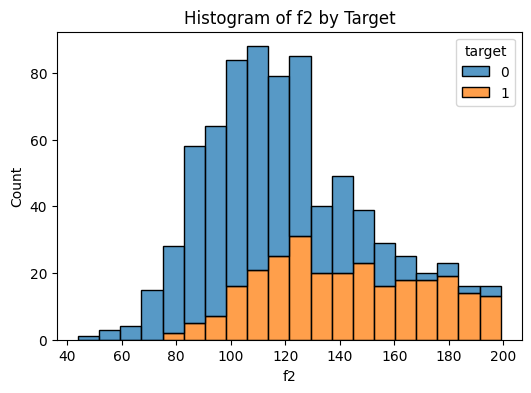

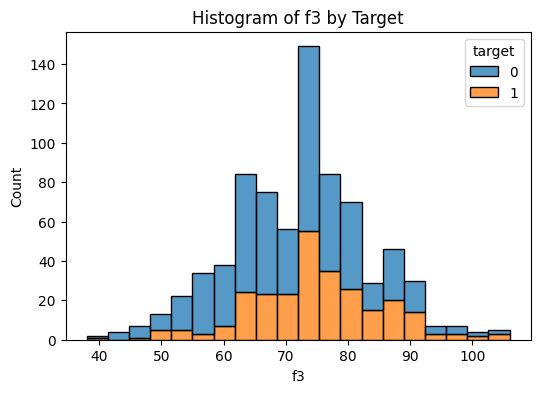

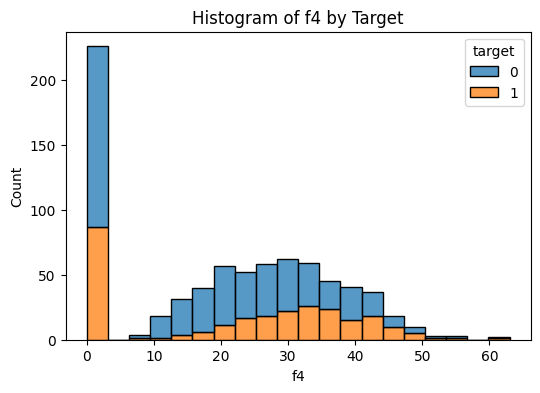

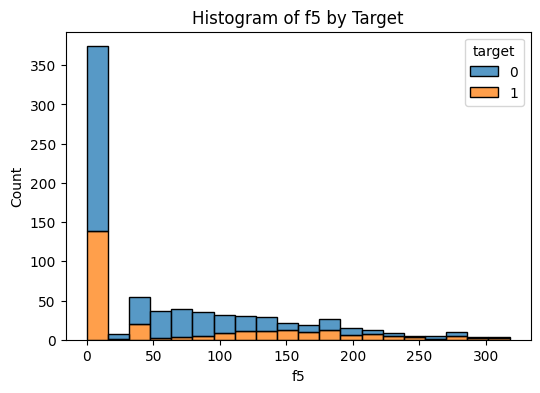

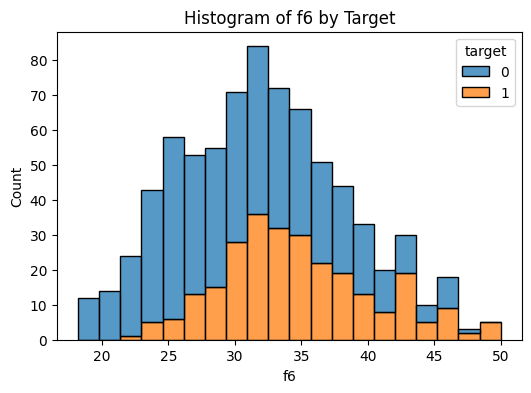

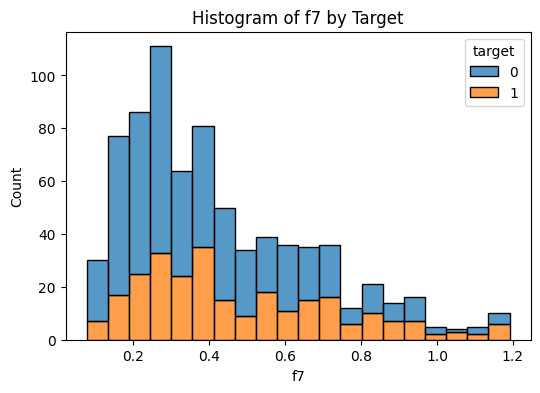

In [313]:
import seaborn as sns

# Plot histograms of each feature grouped by the binary target
for feature in ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue='target', multiple="stack", bins=20, kde=False)
    plt.title(f'Histogram of {feature} by Target')
    plt.show()
    print("\n")


## Preparing training and test data

In [314]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve,auc
import time

In [315]:
#Adding class weights for data imbalance handling
from sklearn.utils import class_weight
import numpy as np

In [316]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.array([0,1]), y=df['target'])

In [317]:
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.7690763052208835, 1: 1.4291044776119404}


In [318]:
df['class_weight'] = df['target'].map(class_weight_dict)

In [319]:
df[['target','class_weight']].head(10)

,target,class_weight
0,1,1.429104
1,0,0.769076
2,1,1.429104
3,0,0.769076
4,1,1.429104
5,0,0.769076
6,1,1.429104
7,0,0.769076
8,1,1.429104
9,1,1.429104


In [320]:
Y=df['target']
X=df.drop("target",axis=1)

In [321]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20,random_state=42)

In [322]:
#train and validation set split
x_train,x_validate,y_train,y_validate=train_test_split(X_train,y_train,test_size=0.25,random_state=42)


In [323]:
print(f'Shapes: X_train: {x_train.shape}, X_validate: {x_validate.shape},  X_test: {X_test.shape},\n y_train:{y_train.shape},y_validate:{y_validate.shape},y_test:{y_test.shape}')

Shapes: X_train: (459, 8), X_validate: (153, 8),  X_test: (154, 8),
 y_train:(459,),y_validate:(153,),y_test:(154,)


In [324]:
#Standardiser
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train=scaler.fit_transform(x_train)
x_test=scaler.fit_transform(X_test)
x_validate=scaler.fit_transform(x_validate)

In [325]:
print(x_train)

[[-1.17928199 -1.80549664  0.419675   ...  2.09186648 -0.9689403
  -0.73151696]
 [-1.17928199  0.2927932   0.77872594 ... -0.13604505  1.05877823
  -0.73151696]
 [ 0.08026527 -1.19631572 -1.19605421 ... -0.67327225 -0.5227626
  -0.73151696]
 ...
 [-0.23462155 -0.68866495  0.59920047 ...  0.71719739 -0.1004872
   1.36702231]
 [ 1.33981252 -0.01179726  0.59920047 ... -1.11569432 -0.11243836
  -0.73151696]
 [-1.17928199 -0.45176126 -0.83700327 ...  0.71719739  1.27389972
   1.36702231]]


In [326]:
#changing x and y to tensors
x_train_tensor=torch.tensor(x_train,dtype=torch.float32)
x_test_tensor=torch.tensor(x_test,dtype=torch.float32)
x_validate_tensor=torch.tensor(x_validate,dtype=torch.float32)
y_train_tensor=torch.tensor(y_train.values,dtype=torch.float32)
y_test_tensor=torch.tensor(y_test.values,dtype=torch.float32)
y_validate_tensor=torch.tensor(y_validate.values,dtype=torch.float32)

In [327]:
print(x_train_tensor)

tensor([[-1.1793, -1.8055,  0.4197,  ...,  2.0919, -0.9689, -0.7315],
        [-1.1793,  0.2928,  0.7787,  ..., -0.1360,  1.0588, -0.7315],
        [ 0.0803, -1.1963, -1.1961,  ..., -0.6733, -0.5228, -0.7315],
        ...,
        [-0.2346, -0.6887,  0.5992,  ...,  0.7172, -0.1005,  1.3670],
        [ 1.3398, -0.0118,  0.5992,  ..., -1.1157, -0.1124, -0.7315],
        [-1.1793, -0.4518, -0.8370,  ...,  0.7172,  1.2739,  1.3670]])


## Defining neural network

In [328]:
#Defining neural network
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [329]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [209]:
!pip install torchinfo

In [362]:
import torchinfo
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.6, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.6, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [363]:
#Model summary using torchinfo
torchinfo.summary(model,input_size=(1,8))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

### Training Neural Network


In [364]:
loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.00001) #Optimizer function

In [365]:
# Creating training, validation and testing dataset
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validation_dataset=TensorDataset(x_validate_tensor,y_validate_tensor)
test_dataset=TensorDataset(x_test_tensor,y_test_tensor)


In [366]:
# Creating a DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size)

In [367]:
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)

In [368]:
test_loader=DataLoader(test_dataset,batch_size=batch_size)

In [369]:
start_time = time.time()
best_val_accuracy = 0.0  # Track the best validation accuracy
best_model_weights = None
epochs=100
loss_t=[]
accuracy_t=[]
loss_val=[]
accuracy_val=[]
for epoch in range(epochs):

    #training phase
    model.train()
    total_batch_loss=0.0
    correct_predictions=0
    total_samples=0
    for X, Y in train_loader:

      outputs=model(X)
      #print(outputs)
      y_pred=outputs.squeeze()
      loss=loss_function(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_batch_loss+=loss.item()
      #print(loss.item())
      predictions = torch.round(y_pred)
      correct_predictions+=(predictions==Y).sum().item()
      total_samples+=Y.size(0)

    #training loss for the epoch
    avg_loss=total_batch_loss/len(train_loader)
    loss_t.append(avg_loss)

    #accuracy for the epoch
    accuracy=correct_predictions/total_samples
    accuracy_t.append(accuracy)

    model.eval()
    total_batch_loss_val=0.0
    correct_pred_val=0
    total_samples_val=0

    #validation
    with torch.no_grad():
      for X_val,Y_val in validation_loader:
        outputs_val=model(X_val)
        y_pred_val=outputs_val.squeeze()
        val_loss=loss_function(y_pred_val,Y_val)
        total_batch_loss_val+=val_loss.item()
        pred_val=torch.round(y_pred_val)
        correct_pred_val+=(pred_val==Y_val).sum().item()
        total_samples_val+=Y_val.size(0)

    avg_loss_val=total_batch_loss_val/len(validation_loader)
    loss_val.append(avg_loss_val)

    acc_val=correct_pred_val/total_samples_val
    accuracy_val.append(acc_val)

    if acc_val > best_val_accuracy:
        best_val_accuracy = acc_val
        best_model_weights = model.state_dict()

    if (epoch+1) % 10 ==0:
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")

end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

torch.save(best_model_weights, 'part1_model.pt')
print(f"Best model saved with validation accuracy: {best_val_accuracy:.2f}")





Epoch [10/100], Train Loss: 0.69, Val Loss: 0.68
Epoch [20/100], Train Loss: 0.70, Val Loss: 0.67
Epoch [30/100], Train Loss: 0.68, Val Loss: 0.67
Epoch [40/100], Train Loss: 0.67, Val Loss: 0.67
Epoch [50/100], Train Loss: 0.67, Val Loss: 0.66
Epoch [60/100], Train Loss: 0.67, Val Loss: 0.66
Epoch [70/100], Train Loss: 0.67, Val Loss: 0.66
Epoch [80/100], Train Loss: 0.65, Val Loss: 0.65
Epoch [90/100], Train Loss: 0.67, Val Loss: 0.65
Epoch [100/100], Train Loss: 0.65, Val Loss: 0.64
Total training time: 7.93 seconds
Best model saved with validation accuracy: 0.78


In [370]:
#loading back the model with best weights
model.load_state_dict(torch.load('part1_model.pt'))

#testing the model
model.eval()
total_batch_loss_test=0
correct_pred_test=0
total_samples_test=0
loss_test=[]
accuracy_test=[]

pred=[]
actuals=[]
probabilities=[]


with torch.no_grad():
  for X_test_,Y_test_ in test_loader:
    output_test=model(X_test_)
    y_pred_test=output_test.squeeze()

    test_loss=loss_function(y_pred_test,Y_test_)
    total_batch_loss_test+=test_loss.item()

    pred_test=torch.round(y_pred_test)
    correct_pred_test+=(pred_test==Y_test_).sum().item()
    total_samples_test+=Y_test_.size(0)

    pred.extend(pred_test.numpy())
    actuals.extend(Y_test_.numpy())

    probabilities.extend(torch.sigmoid(y_pred_test).numpy())

avg_loss_test=total_batch_loss_test/len(test_loader)
acc_test=correct_pred_test/total_samples_test

loss_test=[avg_loss for i in range(epochs)]
accuracy_test=[acc_test for i in range(epochs)]

#print(len(loss_test))
#print(len(accuracy_test))
#print(loss_test)
print(f"Test accuracy is {acc_test}")



Test accuracy is 0.7727272727272727


<ipython-input-370-1048a0321c12>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('part1_model.pt'))


In [371]:
#Using pytorch metrics to show accuracy, precision, recall, f1 score
accuracy = accuracy_score(actuals, pred)
precision = precision_score(actuals, pred)
recall = recall_score(actuals, pred)
f1 = f1_score(actuals, pred)

print(f"Accuracy using pytorch method: {accuracy}")
print(f"Precision using pytorch method: {precision}")
print(f"Recall using pytorch method: {recall}")
print(f"f1 score using pytorch method: {f1}")

Accuracy using pytorch method: 0.7727272727272727
Precision using pytorch method: 0.875
Recall using pytorch method: 0.39622641509433965
f1 score using pytorch method: 0.5454545454545454


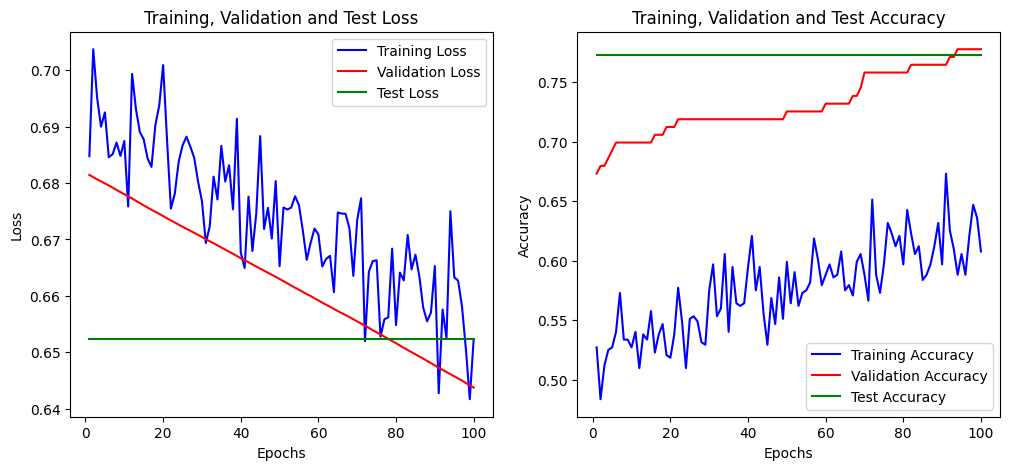

In [372]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_t) + 1), loss_t, 'b', label='Training Loss')
plt.plot(range(1, len(loss_val) + 1), loss_val, 'r', label='Validation Loss')
plt.plot(range(1, len(loss_test) + 1),loss_test,color='green',label="Test Loss")
plt.title('Training, Validation and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1, len(accuracy_t) + 1), accuracy_t, 'b', label='Training Accuracy')
plt.plot(range(1, len(accuracy_val) + 1), accuracy_val, 'r', label='Validation Accuracy')
plt.plot(range(1, len(accuracy_test) + 1),accuracy_test,color='green',label="Test Accuracy")
plt.title('Training, Validation and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

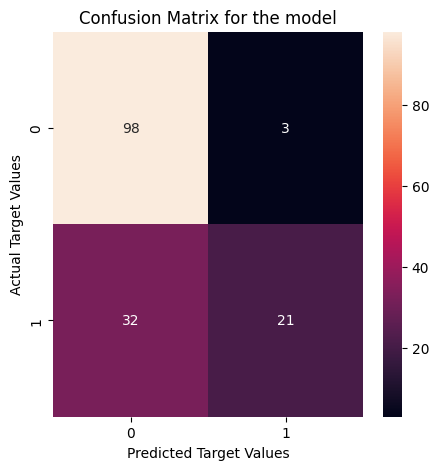

In [373]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(actuals),np.array(pred))
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,xticklabels=['0', '1'], yticklabels=['0', '1'],fmt='d')
plt.xlabel('Predicted Target Values')
plt.ylabel('Actual Target Values')
plt.title('Confusion Matrix for the model')
plt.show()

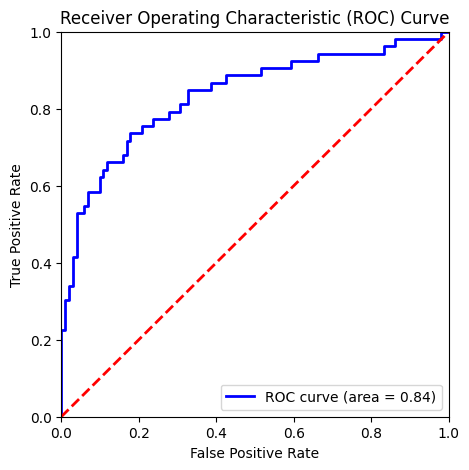

In [374]:
#ROC curve
fpr, tpr, thresholds = roc_curve(np.array(actuals), np.array(probabilities))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



# **Hyperparameter tuning**

##### Hyperparameter for tuning: Dropout rate
- Dropout rate values: 0.3, 0.4, 0.5

In [379]:
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size)

In [396]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import pandas as pd

Accuracy_table = {}  # To store accuracy for each dropout rate
Best_setup = {}  # To store the loss/accuracy of the best performing model
best_test_accuracy = 0.0  # Track the highest test accuracy

for rate in [0.3, 0.4, 0.5]:
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.flatten = nn.Flatten()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(8, 32),
                nn.ReLU(),
                nn.Dropout(rate),
                nn.Linear(32, 16),
                nn.ReLU(),
                nn.Dropout(rate),
                nn.Linear(16, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.flatten(x)
            logits = self.linear_relu_stack(x)
            return logits

    model = NeuralNetwork().to(device)
    print(torchinfo.summary(model, input_size=(1, 8)))

    loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.00001)

    start_time = time.time()
    best_val_accuracy = 0.0
    temp_model_weights = None
    epochs = 100

    # Store metrics for this setup
    loss_t, accuracy_t = [], []
    loss_val, accuracy_val = [], []

    print(f"Dropout rate: {rate}")
    for epoch in range(epochs):
        # Training phase
        model.train()
        total_batch_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for X, Y in train_loader:
            outputs = model(X)
            y_pred = outputs.squeeze()
            loss = loss_function(y_pred, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_batch_loss += loss.item()
            predictions = torch.round(y_pred)
            correct_predictions += (predictions == Y).sum().item()
            total_samples += Y.size(0)

        avg_loss = total_batch_loss / len(train_loader)
        loss_t.append(avg_loss)

        accuracy = correct_predictions / total_samples
        accuracy_t.append(accuracy)

        # Validation phase
        model.eval()
        total_batch_loss_val = 0.0
        correct_pred_val = 0
        total_samples_val = 0

        with torch.no_grad():
            for X_val, Y_val in validation_loader:
                outputs_val = model(X_val)
                y_pred_val = outputs_val.squeeze()
                val_loss = loss_function(y_pred_val, Y_val)

                total_batch_loss_val += val_loss.item()
                pred_val = torch.round(y_pred_val)
                correct_pred_val += (pred_val == Y_val).sum().item()
                total_samples_val += Y_val.size(0)

        avg_loss_val = total_batch_loss_val / len(validation_loader)
        loss_val.append(avg_loss_val)

        acc_val = correct_pred_val / total_samples_val
        accuracy_val.append(acc_val)

        if acc_val > best_val_accuracy:
            best_val_accuracy = acc_val
            temp_model_weights = model.state_dict()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")

    end_time = time.time()
    training_time = end_time - start_time
    print(f"Total training time: {training_time:.2f} seconds")

    torch.save(temp_model_weights, 'temp_model.pt')

    # Load the best model for testing
    model.load_state_dict(torch.load('temp_model.pt'))
    model.eval()
    total_batch_loss_test = 0
    correct_pred_test = 0
    total_samples_test = 0

    pred, actuals, probabilities = [], [], []

    with torch.no_grad():
        for X_test_, Y_test_ in test_loader:
            output_test = model(X_test_)
            y_pred_test = output_test.squeeze()

            test_loss = loss_function(y_pred_test, Y_test_)
            total_batch_loss_test += test_loss.item()

            pred_test = torch.round(y_pred_test)
            correct_pred_test += (pred_test == Y_test_).sum().item()
            total_samples_test += Y_test_.size(0)

            pred.extend(pred_test.numpy())
            actuals.extend(Y_test_.numpy())
            probabilities.extend(torch.sigmoid(y_pred_test).numpy())

    avg_loss_test = total_batch_loss_test / len(test_loader)
    acc_test = correct_pred_test / total_samples_test

    print(f"Accuracy of test is {acc_test}")

    # Store test accuracy for this setup
    Accuracy_table[rate] = acc_test

    # If this setup has the best test accuracy, store its metrics
    if acc_test > best_test_accuracy:
        best_test_accuracy = acc_test
        Best_setup = {
            "dropout_rate": rate,
            "train_loss": loss_t,
            "val_loss": loss_val,
            "test_loss": [avg_loss_test] * epochs,
            "train_accuracy": accuracy_t,
            "val_accuracy": accuracy_val,
            "test_accuracy": [acc_test] * epochs
        }

# Display all accuracies for different dropout rates
print(Accuracy_table)
acc_df = pd.DataFrame(list(Accuracy_table.items()), columns=['Dropout Rate', 'Test Accuracy'])
acc_df.index = [f'Setup{i}#' for i in range(1, len(acc_df) + 1)]
print("Dropout Tuning Results:")
print(acc_df)

# Display the best setup
print("\nBest Setup:")
print(f"Dropout Rate: {Best_setup['dropout_rate']}")
print(f"Test Accuracy: {Best_setup['test_accuracy'][0]}")


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

<ipython-input-396-474c4a7265be>:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


Epoch [10/100], Train Loss: 0.66, Val Loss: 0.67
Epoch [20/100], Train Loss: 0.67, Val Loss: 0.67
Epoch [30/100], Train Loss: 0.66, Val Loss: 0.66
Epoch [40/100], Train Loss: 0.66, Val Loss: 0.66
Epoch [50/100], Train Loss: 0.66, Val Loss: 0.66
Epoch [60/100], Train Loss: 0.65, Val Loss: 0.66
Epoch [70/100], Train Loss: 0.65, Val Loss: 0.65
Epoch [80/100], Train Loss: 0.65, Val Loss: 0.65
Epoch [90/100], Train Loss: 0.64, Val Loss: 0.65
Epoch [100/100], Train Loss: 0.64, Val Loss: 0.64
Total training time: 8.60 seconds
Accuracy of test is 0.6558441558441559
Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dro

-  Best dropout rate: 0.3 generating accuracy = 0.89 <br>
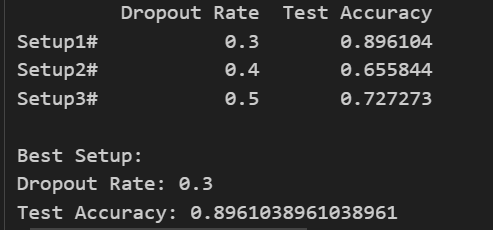

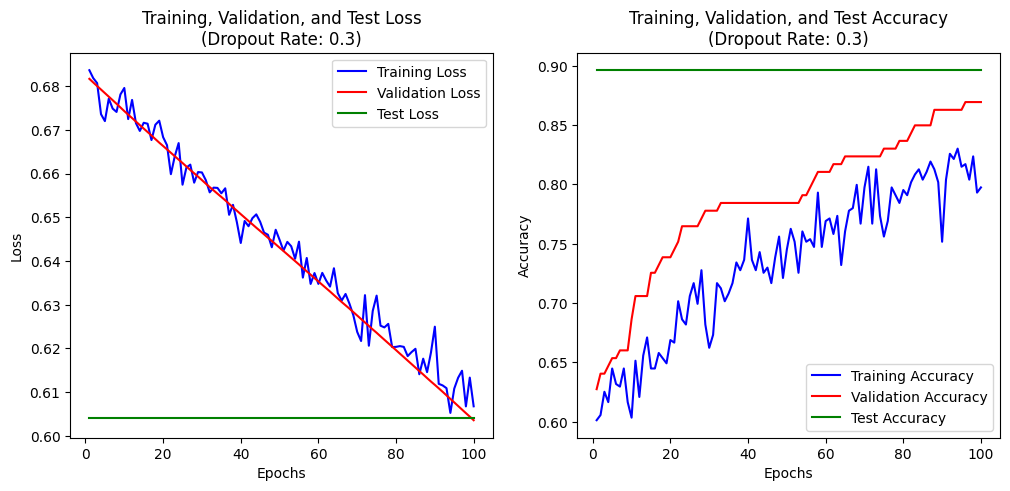

In [397]:
# Plot the metrics of the best setup
plt.figure(figsize=(12, 5))

# Plot Losses
plt.subplot(1, 2, 1)
plt.plot(range(1, len(Best_setup['train_loss']) + 1), Best_setup['train_loss'], 'b', label='Training Loss')
plt.plot(range(1, len(Best_setup['val_loss']) + 1), Best_setup['val_loss'], 'r', label='Validation Loss')
plt.plot(range(1, len(Best_setup['test_loss']) + 1), Best_setup['test_loss'], color='green', label='Test Loss')
plt.title(f'Training, Validation, and Test Loss\n(Dropout Rate: {Best_setup["dropout_rate"]})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracies
plt.subplot(1, 2, 2)
plt.plot(range(1, len(Best_setup['train_accuracy']) + 1), Best_setup['train_accuracy'], 'b', label='Training Accuracy')
plt.plot(range(1, len(Best_setup['val_accuracy']) + 1), Best_setup['val_accuracy'], 'r', label='Validation Accuracy')
plt.plot(range(1, len(Best_setup['test_accuracy']) + 1), Best_setup['test_accuracy'], color='green', label='Test Accuracy')
plt.title(f'Training, Validation, and Test Accuracy\n(Dropout Rate: {Best_setup["dropout_rate"]})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


- inference : dropout rate 0.3 works best for this model

### Hyperparameter tuning of batch size values [30, 64, 100]

In [419]:
Accuracy_table={}
for size in [30,64,100]:
  batch_size = size
  train_loader = DataLoader(train_dataset, batch_size=batch_size)
  validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
  test_loader=DataLoader(test_dataset,batch_size=batch_size)
  class NeuralNetwork(nn.Module):
      def __init__(self):
          super(NeuralNetwork,self).__init__()
          self.flatten = nn.Flatten()
          self.linear_relu_stack = nn.Sequential(
              nn.Linear(8, 32),
              nn.ReLU(),
              nn.Dropout(0.3),
              nn.Linear(32, 16),
              nn.ReLU(),
              nn.Dropout(0.3),
              nn.Linear(16, 1),
              nn.Sigmoid()
          )

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  model = NeuralNetwork().to(device)
  print(torchinfo.summary(model,input_size=(1,8)))

  loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
  optimizer = optim.Adam(model.parameters(), lr=0.00001)


  start_time = time.time()
  best_val_accuracy = 0.0  # Track the best validation accuracy
  temp_model_weights = None
  epochs=100
  loss_t=[]
  accuracy_t=[]
  loss_val=[]
  accuracy_val=[]

  print(f"Batch size: {size}")
  for epoch in range(epochs):

      #training phase
      model.train()
      total_batch_loss=0.0
      correct_predictions=0
      total_samples=0
      for X, Y in train_loader:

        outputs=model(X)
        #print(outputs)
        y_pred=outputs.squeeze()
        loss=loss_function(y_pred,Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_batch_loss+=loss.item()
        #print(loss.item())
        predictions = torch.round(y_pred)
        correct_predictions+=(predictions==Y).sum().item()
        total_samples+=Y.size(0)

      #training loss for the epoch
      avg_loss=total_batch_loss/len(train_loader)
      loss_t.append(avg_loss)

      #accuracy for the epoch
      accuracy=correct_predictions/total_samples
      accuracy_t.append(accuracy)

      model.eval()
      total_batch_loss_val=0.0
      correct_pred_val=0
      total_samples_val=0

      with torch.no_grad():
        for X_val,Y_val in validation_loader:
          outputs_val=model(X_val)
          y_pred_val=outputs_val.squeeze()
          val_loss=loss_function(y_pred_val,Y_val)
          total_batch_loss_val+=val_loss.item()
          pred_val=torch.round(y_pred_val)
          correct_pred_val+=(pred_val==Y_val).sum().item()
          total_samples_val+=Y_val.size(0)

      avg_loss_val=total_batch_loss_val/len(validation_loader)
      loss_val.append(avg_loss_val)

      acc_val=correct_pred_val/total_samples_val
      accuracy_val.append(acc_val)

      if acc_val > best_val_accuracy:
          best_val_accuracy = acc_val
          temp_model_weights = model.state_dict()

      if (epoch+1) % 10 ==0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")

  end_time = time.time()
  training_time = end_time - start_time
  print(f"Total training time: {training_time:.2f} seconds")

  torch.save(temp_model_weights, 'temp_model.pt')

  model.load_state_dict(torch.load('temp_model.pt'))
  model.eval()
  total_batch_loss_test=0
  correct_pred_test=0
  total_samples_test=0
  loss_test=[]
  accuracy_test=[]

  pred=[]
  actuals=[]
  probabilities=[]


  with torch.no_grad():
    for X_test_,Y_test_ in test_loader:
      output_test=model(X_test_)
      y_pred_test=output_test.squeeze()

      test_loss=loss_function(y_pred_test,Y_test_)
      total_batch_loss_test+=test_loss.item()

      pred_test=torch.round(y_pred_test)
      correct_pred_test+=(pred_test==Y_test_).sum().item()
      total_samples_test+=Y_test_.size(0)

      pred.extend(pred_test.numpy())
      actuals.extend(Y_test_.numpy())

      probabilities.extend(torch.sigmoid(y_pred_test).numpy())

  avg_loss_test=total_batch_loss_test/len(test_loader)
  acc_test=correct_pred_test/total_samples_test

  loss_test=[avg_loss for i in range(epochs)]
  accuracy_test=[acc_test for i in range(epochs)]

  print(f"Accurcay of test is {accuracy_test[0]}")


  Accuracy_table[size]=accuracy_test[0]


print(Accuracy_table)
acc_df=pd.DataFrame(list(Accuracy_table.items()),columns=['Value','Test accuracy'])
acc_df.index = [f'Setup{i}#' for i in range(1, len(acc_df) + 1)]
print("Batch size tuning")
print(acc_df)


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

<ipython-input-419-ab633afa06a0>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


Epoch [10/100], Train Loss: 0.70, Val Loss: 0.70
Epoch [20/100], Train Loss: 0.71, Val Loss: 0.70
Epoch [30/100], Train Loss: 0.71, Val Loss: 0.70
Epoch [40/100], Train Loss: 0.70, Val Loss: 0.70
Epoch [50/100], Train Loss: 0.70, Val Loss: 0.70
Epoch [60/100], Train Loss: 0.70, Val Loss: 0.70
Epoch [70/100], Train Loss: 0.70, Val Loss: 0.70
Epoch [80/100], Train Loss: 0.70, Val Loss: 0.70
Epoch [90/100], Train Loss: 0.70, Val Loss: 0.70
Epoch [100/100], Train Loss: 0.70, Val Loss: 0.69
Total training time: 2.53 seconds
Accurcay of test is 0.37012987012987014
Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dr

- Optimal batch size is 100 which generates an accuracy of 0.77 <br>
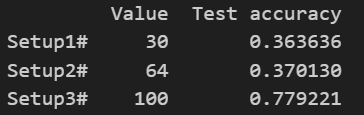

### Hyperparameter tuning: Learning rate ; Values: [0.0001,0.000001,0.0000001]

In [420]:
Accuracy_table={}
for rate in [0.0001,0.000001,0.0000001]:
  batch_size = 100
  train_loader = DataLoader(train_dataset, batch_size=batch_size)
  validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
  test_loader=DataLoader(test_dataset,batch_size=batch_size)
  class NeuralNetwork(nn.Module):
      def __init__(self):
          super(NeuralNetwork,self).__init__()
          self.flatten = nn.Flatten()
          self.linear_relu_stack = nn.Sequential(
              nn.Linear(8, 32),
              nn.ReLU(),
              nn.Dropout(0.3),
              nn.Linear(32, 16),
              nn.ReLU(),
              nn.Dropout(0.3),
              nn.Linear(16, 1),
              nn.Sigmoid()
          )

      def forward(self, x):
          x = self.flatten(x)
          logits = self.linear_relu_stack(x)
          return logits
  model = NeuralNetwork().to(device)
  print(torchinfo.summary(model,input_size=(1,8)))

  loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
  optimizer = optim.Adam(model.parameters(), lr=rate)


  start_time = time.time()
  best_val_accuracy = 0.0  # Track the best validation accuracy
  temp_model_weights = None
  epochs=100
  loss_t=[]
  accuracy_t=[]
  loss_val=[]
  accuracy_val=[]

  print(f"Learning rate: {rate}")
  for epoch in range(epochs):

      #training phase
      model.train()
      total_batch_loss=0.0
      correct_predictions=0
      total_samples=0
      for X, Y in train_loader:

        outputs=model(X)
        #print(outputs)
        y_pred=outputs.squeeze()
        loss=loss_function(y_pred,Y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_batch_loss+=loss.item()
        #print(loss.item())
        predictions = torch.round(y_pred)
        correct_predictions+=(predictions==Y).sum().item()
        total_samples+=Y.size(0)

      #training loss for the epoch
      avg_loss=total_batch_loss/len(train_loader)
      loss_t.append(avg_loss)

      #accuracy for the epoch
      accuracy=correct_predictions/total_samples
      accuracy_t.append(accuracy)

      model.eval()
      total_batch_loss_val=0.0
      correct_pred_val=0
      total_samples_val=0

      with torch.no_grad():
        for X_val,Y_val in validation_loader:
          outputs_val=model(X_val)
          y_pred_val=outputs_val.squeeze()
          val_loss=loss_function(y_pred_val,Y_val)
          total_batch_loss_val+=val_loss.item()
          pred_val=torch.round(y_pred_val)
          correct_pred_val+=(pred_val==Y_val).sum().item()
          total_samples_val+=Y_val.size(0)

      avg_loss_val=total_batch_loss_val/len(validation_loader)
      loss_val.append(avg_loss_val)

      acc_val=correct_pred_val/total_samples_val
      accuracy_val.append(acc_val)

      if acc_val > best_val_accuracy:
          best_val_accuracy = acc_val
          temp_model_weights = model.state_dict()

      if (epoch+1) % 10 ==0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")

  end_time = time.time()
  training_time = end_time - start_time
  print(f"Total training time: {training_time:.2f} seconds")

  torch.save(temp_model_weights, 'temp_model.pt')

  model.load_state_dict(torch.load('temp_model.pt'))
  model.eval()
  total_batch_loss_test=0
  correct_pred_test=0
  total_samples_test=0
  loss_test=[]
  accuracy_test=[]

  pred=[]
  actuals=[]
  probabilities=[]


  with torch.no_grad():
    for X_test_,Y_test_ in test_loader:
      output_test=model(X_test_)
      y_pred_test=output_test.squeeze()

      test_loss=loss_function(y_pred_test,Y_test_)
      total_batch_loss_test+=test_loss.item()

      pred_test=torch.round(y_pred_test)
      correct_pred_test+=(pred_test==Y_test_).sum().item()
      total_samples_test+=Y_test_.size(0)

      pred.extend(pred_test.numpy())
      actuals.extend(Y_test_.numpy())

      probabilities.extend(torch.sigmoid(y_pred_test).numpy())

  avg_loss_test=total_batch_loss_test/len(test_loader)
  acc_test=correct_pred_test/total_samples_test

  loss_test=[avg_loss for i in range(epochs)]
  accuracy_test=[acc_test for i in range(epochs)]

  print(f"Accurcay of test is {accuracy_test[0]}")


  Accuracy_table[rate]=accuracy_test[0]


print(Accuracy_table)
acc_df=pd.DataFrame(list(Accuracy_table.items()),columns=['Value','Test accuracy'])
acc_df.index = [f'Setup{i}#' for i in range(1, len(acc_df) + 1)]
print("Learning Rate tuning")
print(acc_df)


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

<ipython-input-420-6be491a1b49f>:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


Epoch [20/100], Train Loss: 0.69, Val Loss: 0.69
Epoch [30/100], Train Loss: 0.69, Val Loss: 0.69
Epoch [40/100], Train Loss: 0.69, Val Loss: 0.69
Epoch [50/100], Train Loss: 0.69, Val Loss: 0.69
Epoch [60/100], Train Loss: 0.69, Val Loss: 0.69
Epoch [70/100], Train Loss: 0.68, Val Loss: 0.69
Epoch [80/100], Train Loss: 0.69, Val Loss: 0.69
Epoch [90/100], Train Loss: 0.69, Val Loss: 0.69
Epoch [100/100], Train Loss: 0.68, Val Loss: 0.69
Total training time: 2.13 seconds
Accurcay of test is 0.6688311688311688
Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]           

- Learning rate of 0.0001 works best for the model, generating accuracy of 0.98 <br>
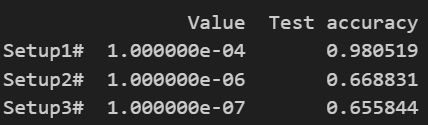

- The original model can be modified with dropout rate= 0.3, learning rate=0.0001 and batch size = 100. Creating base model on this basis: 

## Defining base model


In [450]:
#Accuracy_table={}
#for rate in [0.0001,0.000001,0.001,0.00001]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(torchinfo.summary(model,input_size=(1,8)))
loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)
start_time = time.time()
best_val_accuracy = 0.0  # Track the best validation accuracy
temp_model_weights = None
epochs=100
loss_t=[]
accuracy_t=[]
loss_val=[]
accuracy_val=[]
print(f"Learning rate: {rate}")
for epoch in range(epochs):
    #training phase
    model.train()
    total_batch_loss=0.0
    correct_predictions=0
    total_samples=0
    for X, Y in train_loader:

      outputs=model(X)
      #print(outputs)
      y_pred=outputs.squeeze()
      loss=loss_function(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_batch_loss+=loss.item()
      #print(loss.item())
      predictions = torch.round(y_pred)
      correct_predictions+=(predictions==Y).sum().item()
      total_samples+=Y.size(0)

    #training loss for the epoch
    avg_loss=total_batch_loss/len(train_loader)
    loss_t.append(avg_loss)
    #accuracy for the epoch
    accuracy=correct_predictions/total_samples
    accuracy_t.append(accuracy)
    model.eval()
    total_batch_loss_val=0.0
    correct_pred_val=0
    total_samples_val=0
    with torch.no_grad():
      for X_val,Y_val in validation_loader:
        outputs_val=model(X_val)
        y_pred_val=outputs_val.squeeze()
        val_loss=loss_function(y_pred_val,Y_val)
        total_batch_loss_val+=val_loss.item()
        pred_val=torch.round(y_pred_val)
        correct_pred_val+=(pred_val==Y_val).sum().item()
        total_samples_val+=Y_val.size(0)
    avg_loss_val=total_batch_loss_val/len(validation_loader)
    loss_val.append(avg_loss_val)
    acc_val=correct_pred_val/total_samples_val
    accuracy_val.append(acc_val)
    if acc_val > best_val_accuracy:
        best_val_accuracy = acc_val
        temp_model_weights = model.state_dict()
    if (epoch+1) % 10 ==0:
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")
torch.save(temp_model_weights, 'temp_model.pt')
model.load_state_dict(torch.load('temp_model.pt'))
model.eval()
total_batch_loss_test=0
correct_pred_test=0
total_samples_test=0
loss_test=[]
accuracy_test=[]
pred=[]
actuals=[]
probabilities=[]
with torch.no_grad():
  for X_test_,Y_test_ in test_loader:
    output_test=model(X_test_)
    y_pred_test=output_test.squeeze()
    test_loss=loss_function(y_pred_test,Y_test_)
    total_batch_loss_test+=test_loss.item()
    pred_test=torch.round(y_pred_test)
    correct_pred_test+=(pred_test==Y_test_).sum().item()
    total_samples_test+=Y_test_.size(0)
    pred.extend(pred_test.numpy())
    actuals.extend(Y_test_.numpy())
    probabilities.extend(torch.sigmoid(y_pred_test).numpy())
avg_loss_test=total_batch_loss_test/len(test_loader)
acc_test=correct_pred_test/total_samples_test
#loss_test=[avg_loss for i in range(epochs)]
#accuracy_test=[acc_test for i in range(epochs)]

base_test_accuracy=acc_test
base_training_time=training_time

print(f"Test accuracy:{round(acc_test,2)}")


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

<ipython-input-450-eab6a88a3843>:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


- Accuracy for the improved model: 0.86. Total training time: 2.97s

#### Implementing additional optimization techniques to find out ideal enhancements

#### 1. Adding learning rate scheduler

In [447]:
#Accuracy_table={}
#for rate in [0.0001,0.000001,0.001,0.00001]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(torchinfo.summary(model,input_size=(1,8)))

loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.01)

start_time = time.time()
best_val_accuracy = 0.0  # Track the best validation accuracy
temp_model_weights = None
epochs=100
loss_t=[]
accuracy_t=[]
loss_val=[]
accuracy_val=[]
print(f"Learning rate: {rate}")
for epoch in range(epochs):
    #training phase
    model.train()
    total_batch_loss=0.0
    correct_predictions=0
    total_samples=0
    for X, Y in train_loader:

      outputs=model(X)
      #print(outputs)
      y_pred=outputs.squeeze()
      loss=loss_function(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_batch_loss+=loss.item()
      #print(loss.item())
      predictions = torch.round(y_pred)
      correct_predictions+=(predictions==Y).sum().item()
      total_samples+=Y.size(0)

    #training loss for the epoch
    avg_loss=total_batch_loss/len(train_loader)
    loss_t.append(avg_loss)
    #accuracy for the epoch
    accuracy=correct_predictions/total_samples
    accuracy_t.append(accuracy)
    model.eval()
    total_batch_loss_val=0.0
    correct_pred_val=0
    total_samples_val=0
    with torch.no_grad():
      for X_val,Y_val in validation_loader:
        outputs_val=model(X_val)
        y_pred_val=outputs_val.squeeze()
        val_loss=loss_function(y_pred_val,Y_val)
        total_batch_loss_val+=val_loss.item()
        pred_val=torch.round(y_pred_val)
        correct_pred_val+=(pred_val==Y_val).sum().item()
        total_samples_val+=Y_val.size(0)
    avg_loss_val=total_batch_loss_val/len(validation_loader)
    loss_val.append(avg_loss_val)
    acc_val=correct_pred_val/total_samples_val
    accuracy_val.append(acc_val)
    if acc_val > best_val_accuracy:
        best_val_accuracy = acc_val
        temp_model_weights = model.state_dict()

    scheduler.step()

    if (epoch+1) % 10 ==0:
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")
torch.save(temp_model_weights, 'temp_model.pt')
model.load_state_dict(torch.load('temp_model.pt'))
model.eval()
total_batch_loss_test=0
correct_pred_test=0
total_samples_test=0
loss_test=[]
accuracy_test=[]
pred=[]
actuals=[]
probabilities=[]
with torch.no_grad():
  for X_test_,Y_test_ in test_loader:
    output_test=model(X_test_)
    y_pred_test=output_test.squeeze()
    test_loss=loss_function(y_pred_test,Y_test_)
    total_batch_loss_test+=test_loss.item()
    pred_test=torch.round(y_pred_test)
    correct_pred_test+=(pred_test==Y_test_).sum().item()
    total_samples_test+=Y_test_.size(0)
    pred.extend(pred_test.numpy())
    actuals.extend(Y_test_.numpy())
    probabilities.extend(torch.sigmoid(y_pred_test).numpy())
avg_loss_test=total_batch_loss_test/len(test_loader)
acc_test=correct_pred_test/total_samples_test
#loss_test=[avg_loss for i in range(epochs)]
#accuracy_test=[acc_test for i in range(epochs)]

print(f"Test accuracy:{round(acc_test,2)}")

opt_1_acc=acc_test
opt_1_time=training_time


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

<ipython-input-447-6fd29b11d8e8>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


- With learning rate scheduler, accuracy is 0.9, and time for training is 2.05 sec

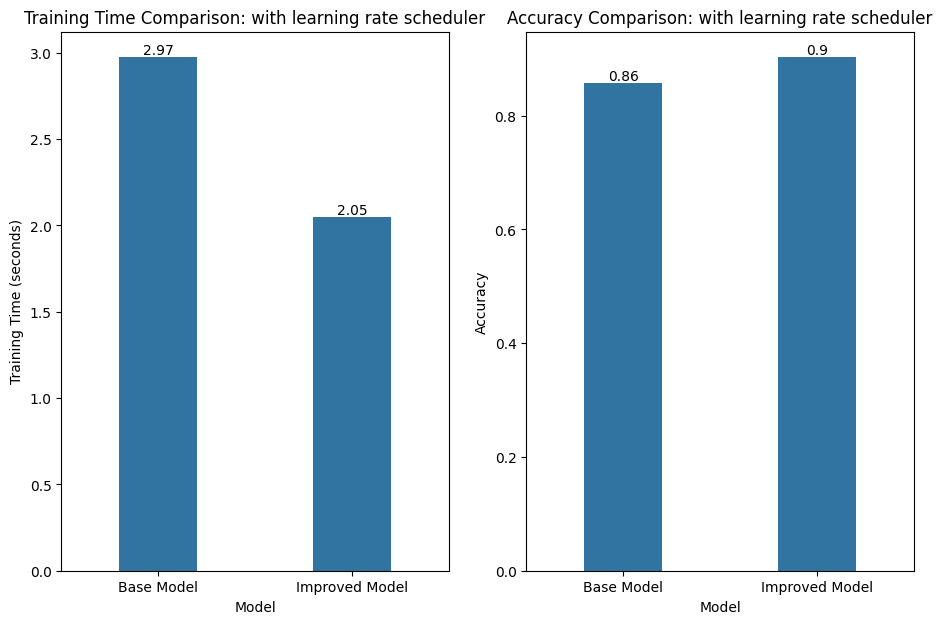

In [451]:
time_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Training Time (seconds)': [base_training_time, opt_1_time]
}

acc_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Test Accuracy': [base_test_accuracy, opt_1_acc]
}

time_df = pd.DataFrame(time_data)
acc_df=pd.DataFrame(acc_data)

plt.figure(figsize=(11, 7))
plt.subplot(1,2,1)
bar_plot=sns.barplot(x='Model', y='Training Time (seconds)', data=time_df, width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Training Time Comparison: with learning rate scheduler')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')

plt.subplot(1,2,2)
#plt.figure(figsize=(3, 3))
bar_plot=sns.barplot(x='Model', y='Test Accuracy', data=acc_df,width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Accuracy Comparison: with learning rate scheduler')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()


#### 2. Adding Batch normalisation

In [454]:
#Accuracy_table={}
#for rate in [0.0001,0.000001,0.001,0.00001]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(torchinfo.summary(model,input_size=(1,8)))

loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start_time = time.time()
best_val_accuracy = 0.0  # Track the best validation accuracy
temp_model_weights = None
epochs=100
loss_t=[]
accuracy_t=[]
loss_val=[]
accuracy_val=[]
print(f"Learning rate: {rate}")
for epoch in range(epochs):
    #training phase
    model.train()
    total_batch_loss=0.0
    correct_predictions=0
    total_samples=0
    for X, Y in train_loader:

      outputs=model(X)
      #print(outputs)
      y_pred=outputs.squeeze()
      loss=loss_function(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_batch_loss+=loss.item()
      #print(loss.item())
      predictions = torch.round(y_pred)
      correct_predictions+=(predictions==Y).sum().item()
      total_samples+=Y.size(0)

    #training loss for the epoch
    avg_loss=total_batch_loss/len(train_loader)
    loss_t.append(avg_loss)
    #accuracy for the epoch
    accuracy=correct_predictions/total_samples
    accuracy_t.append(accuracy)
    model.eval()
    total_batch_loss_val=0.0
    correct_pred_val=0
    total_samples_val=0
    with torch.no_grad():
      for X_val,Y_val in validation_loader:
        outputs_val=model(X_val)
        y_pred_val=outputs_val.squeeze()
        val_loss=loss_function(y_pred_val,Y_val)
        total_batch_loss_val+=val_loss.item()
        pred_val=torch.round(y_pred_val)
        correct_pred_val+=(pred_val==Y_val).sum().item()
        total_samples_val+=Y_val.size(0)
    avg_loss_val=total_batch_loss_val/len(validation_loader)
    loss_val.append(avg_loss_val)
    acc_val=correct_pred_val/total_samples_val
    accuracy_val.append(acc_val)
    if acc_val > best_val_accuracy:
        best_val_accuracy = acc_val
        temp_model_weights = model.state_dict()


    if (epoch+1) % 10 ==0:
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")
torch.save(temp_model_weights, 'temp_model.pt')
model.load_state_dict(torch.load('temp_model.pt'))
model.eval()
total_batch_loss_test=0
correct_pred_test=0
total_samples_test=0
loss_test=[]
accuracy_test=[]
pred=[]
actuals=[]
probabilities=[]
with torch.no_grad():
  for X_test_,Y_test_ in test_loader:
    output_test=model(X_test_)
    y_pred_test=output_test.squeeze()
    test_loss=loss_function(y_pred_test,Y_test_)
    total_batch_loss_test+=test_loss.item()
    pred_test=torch.round(y_pred_test)
    correct_pred_test+=(pred_test==Y_test_).sum().item()
    total_samples_test+=Y_test_.size(0)
    pred.extend(pred_test.numpy())
    actuals.extend(Y_test_.numpy())
    probabilities.extend(torch.sigmoid(y_pred_test).numpy())
avg_loss_test=total_batch_loss_test/len(test_loader)
acc_test=correct_pred_test/total_samples_test
#loss_test=[avg_loss for i in range(epochs)]
#accuracy_test=[acc_test for i in range(epochs)]

print(f"Test accuracy:{round(acc_test,2)}")

opt_2_acc=acc_test
opt_2_time=training_time


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─BatchNorm1d: 2-2                  [1, 32]                   64
│    └─ReLU: 2-3                         [1, 32]                   --
│    └─Dropout: 2-4                      [1, 32]                   --
│    └─Linear: 2-5                       [1, 16]                   528
│    └─BatchNorm1d: 2-6                  [1, 16]                   32
│    └─ReLU: 2-7                         [1, 16]                   --
│    └─Dropout: 2-8                      [1, 16]                   --
│    └─Linear: 2-9                       [1, 1]                    17
│    └─Sigmoid: 2-10                     [1, 1]                    --
Total params:

<ipython-input-454-d7c29fa76e6d>:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


- With batch normalisation, accuracy on test data is 0.99, and time taken for training is 2.29 sec

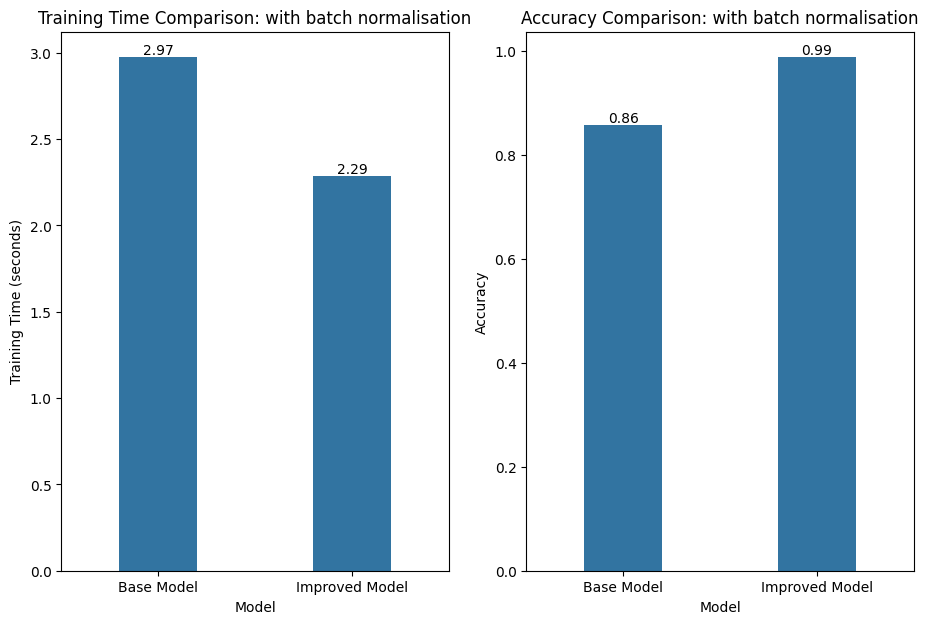

In [455]:
time_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Training Time (seconds)': [base_training_time, opt_2_time]
}

acc_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Test Accuracy': [base_test_accuracy, opt_2_acc]
}

time_df = pd.DataFrame(time_data)
acc_df=pd.DataFrame(acc_data)

plt.figure(figsize=(11, 7))
plt.subplot(1,2,1)
bar_plot=sns.barplot(x='Model', y='Training Time (seconds)', data=time_df, width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Training Time Comparison: with batch normalisation')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')

plt.subplot(1,2,2)
#plt.figure(figsize=(3, 3))
bar_plot=sns.barplot(x='Model', y='Test Accuracy', data=acc_df,width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Accuracy Comparison: with batch normalisation')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()


### 3. Implementing Early stopping

In [460]:
#Accuracy_table={}
#for rate in [0.0001,0.000001,0.001,0.00001]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(torchinfo.summary(model,input_size=(1,8)))

loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

patience = 5  # Number of epochs to wait without improvement
best_val_loss = float('inf')
stop_counter = 0

start_time = time.time()
best_val_accuracy = 0.0  # Track the best validation accuracy
temp_model_weights = None
epochs=100
loss_t=[]
accuracy_t=[]
loss_val=[]
accuracy_val=[]
print(f"Learning rate: {rate}")
for epoch in range(epochs):
    #training phase
    model.train()
    total_batch_loss=0.0
    correct_predictions=0
    total_samples=0
    for X, Y in train_loader:

      outputs=model(X)
      #print(outputs)
      y_pred=outputs.squeeze()
      loss=loss_function(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_batch_loss+=loss.item()
      #print(loss.item())
      predictions = torch.round(y_pred)
      correct_predictions+=(predictions==Y).sum().item()
      total_samples+=Y.size(0)

    #training loss for the epoch
    avg_loss=total_batch_loss/len(train_loader)
    loss_t.append(avg_loss)
    #accuracy for the epoch
    accuracy=correct_predictions/total_samples
    accuracy_t.append(accuracy)
    model.eval()
    total_batch_loss_val=0.0
    correct_pred_val=0
    total_samples_val=0
    with torch.no_grad():
      for X_val,Y_val in validation_loader:
        outputs_val=model(X_val)
        y_pred_val=outputs_val.squeeze()
        val_loss=loss_function(y_pred_val,Y_val)
        total_batch_loss_val+=val_loss.item()
        pred_val=torch.round(y_pred_val)
        correct_pred_val+=(pred_val==Y_val).sum().item()
        total_samples_val+=Y_val.size(0)
    avg_loss_val=total_batch_loss_val/len(validation_loader)
    loss_val.append(avg_loss_val)
    acc_val=correct_pred_val/total_samples_val
    accuracy_val.append(acc_val)
    if acc_val > best_val_accuracy:
        best_val_accuracy = acc_val
        temp_model_weights = model.state_dict()

    #Attempting early stopping
    if avg_loss_val < best_val_loss:
        best_val_loss = avg_loss_val
        stop_counter = 0  # Reset counter if validation loss improves
    else:
        stop_counter += 1  # Increment counter if no improvemen
    # Stop training if validation loss hasn't improved for 'patience' epochs
    if stop_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

    if (epoch+1) % 10 ==0:
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")
torch.save(temp_model_weights, 'temp_model.pt')
model.load_state_dict(torch.load('temp_model.pt'))
model.eval()
total_batch_loss_test=0
correct_pred_test=0
total_samples_test=0
loss_test=[]
accuracy_test=[]
pred=[]
actuals=[]
probabilities=[]
with torch.no_grad():
  for X_test_,Y_test_ in test_loader:
    output_test=model(X_test_)
    y_pred_test=output_test.squeeze()
    test_loss=loss_function(y_pred_test,Y_test_)
    total_batch_loss_test+=test_loss.item()
    pred_test=torch.round(y_pred_test)
    correct_pred_test+=(pred_test==Y_test_).sum().item()
    total_samples_test+=Y_test_.size(0)
    pred.extend(pred_test.numpy())
    actuals.extend(Y_test_.numpy())
    probabilities.extend(torch.sigmoid(y_pred_test).numpy())
avg_loss_test=total_batch_loss_test/len(test_loader)
acc_test=correct_pred_test/total_samples_test
#loss_test=[avg_loss for i in range(epochs)]
#accuracy_test=[acc_test for i in range(epochs)]

print(f"Test accuracy:{round(acc_test,2)}")

opt_3_acc=acc_test
opt_3_time=training_time

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

<ipython-input-460-d8f9001c3160>:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


- With early stopping , accuracy is 0.95 and training time is 1.87 sec

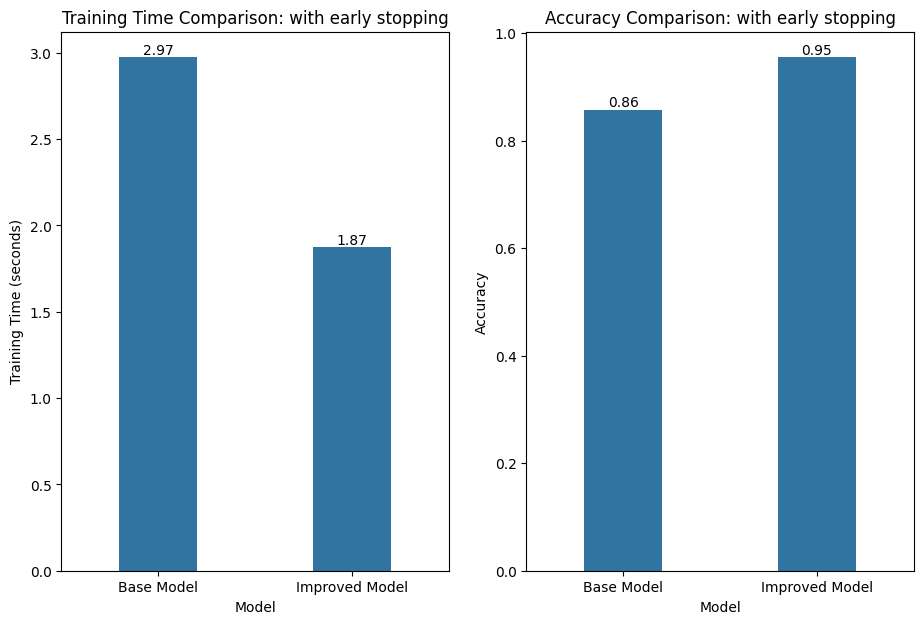

In [461]:
time_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Training Time (seconds)': [base_training_time, opt_3_time]
}

acc_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Test Accuracy': [base_test_accuracy, opt_3_acc]
}

time_df = pd.DataFrame(time_data)
acc_df=pd.DataFrame(acc_data)

plt.figure(figsize=(11, 7))
plt.subplot(1,2,1)
bar_plot=sns.barplot(x='Model', y='Training Time (seconds)', data=time_df, width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Training Time Comparison: with early stopping')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')

plt.subplot(1,2,2)
#plt.figure(figsize=(3, 3))
bar_plot=sns.barplot(x='Model', y='Test Accuracy', data=acc_df,width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Accuracy Comparison: with early stopping')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()


### 4. Implementing Data augmentation - introducing gaussian noise to training X data

In [466]:
#Accuracy_table={}
#for rate in [0.0001,0.000001,0.001,0.00001]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size)

def augment_data(X, noise_factor=0.1, scale_factor=0.1):
    noise = noise_factor * torch.randn_like(X)  # Gaussian noise
    scale = 1.0 + (torch.rand_like(X) - 0.5) * scale_factor  # Random scaling
    return X * scale + noise

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(torchinfo.summary(model,input_size=(1,8)))

loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start_time = time.time()
best_val_accuracy = 0.0  # Track the best validation accuracy
temp_model_weights = None
epochs=100
loss_t=[]
accuracy_t=[]
loss_val=[]
accuracy_val=[]
print(f"Learning rate: {rate}")
for epoch in range(epochs):
    #training phase
    model.train()
    total_batch_loss=0.0
    correct_predictions=0
    total_samples=0
    for X, Y in train_loader:

      X_augmented=augment_data(X)
      outputs=model(X_augmented)
      #print(outputs)
      y_pred=outputs.squeeze()
      loss=loss_function(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_batch_loss+=loss.item()
      #print(loss.item())
      predictions = torch.round(y_pred)
      correct_predictions+=(predictions==Y).sum().item()
      total_samples+=Y.size(0)

    #training loss for the epoch
    avg_loss=total_batch_loss/len(train_loader)
    loss_t.append(avg_loss)
    #accuracy for the epoch
    accuracy=correct_predictions/total_samples
    accuracy_t.append(accuracy)
    model.eval()
    total_batch_loss_val=0.0
    correct_pred_val=0
    total_samples_val=0
    with torch.no_grad():
      for X_val,Y_val in validation_loader:
        outputs_val=model(X_val)
        y_pred_val=outputs_val.squeeze()
        val_loss=loss_function(y_pred_val,Y_val)
        total_batch_loss_val+=val_loss.item()
        pred_val=torch.round(y_pred_val)
        correct_pred_val+=(pred_val==Y_val).sum().item()
        total_samples_val+=Y_val.size(0)
    avg_loss_val=total_batch_loss_val/len(validation_loader)
    loss_val.append(avg_loss_val)
    acc_val=correct_pred_val/total_samples_val
    accuracy_val.append(acc_val)
    if acc_val > best_val_accuracy:
        best_val_accuracy = acc_val
        temp_model_weights = model.state_dict()

    if (epoch+1) % 10 ==0:
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")
torch.save(temp_model_weights, 'temp_model.pt')
model.load_state_dict(torch.load('temp_model.pt'))
model.eval()
total_batch_loss_test=0
correct_pred_test=0
total_samples_test=0
loss_test=[]
accuracy_test=[]
pred=[]
actuals=[]
probabilities=[]
with torch.no_grad():
  for X_test_,Y_test_ in test_loader:
    output_test=model(X_test_)
    y_pred_test=output_test.squeeze()
    test_loss=loss_function(y_pred_test,Y_test_)
    total_batch_loss_test+=test_loss.item()
    pred_test=torch.round(y_pred_test)
    correct_pred_test+=(pred_test==Y_test_).sum().item()
    total_samples_test+=Y_test_.size(0)
    pred.extend(pred_test.numpy())
    actuals.extend(Y_test_.numpy())
    probabilities.extend(torch.sigmoid(y_pred_test).numpy())
avg_loss_test=total_batch_loss_test/len(test_loader)
acc_test=correct_pred_test/total_samples_test
loss_test=[avg_loss for i in range(epochs)]
accuracy_test=[acc_test for i in range(epochs)]

print(f"Test accuracy:{acc_test}")

opt_4_acc=acc_test
opt_4_time=training_time


Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU: 2-2                         [1, 32]                   --
│    └─Dropout: 2-3                      [1, 32]                   --
│    └─Linear: 2-4                       [1, 16]                   528
│    └─ReLU: 2-5                         [1, 16]                   --
│    └─Dropout: 2-6                      [1, 16]                   --
│    └─Linear: 2-7                       [1, 1]                    17
│    └─Sigmoid: 2-8                      [1, 1]                    --
Total params: 833
Trainable params: 833
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Par

<ipython-input-466-f0fbba35a565>:101: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('temp_model.pt'))


- With data augmentation, test accuracy is 0.92 and training time is 1.94sec

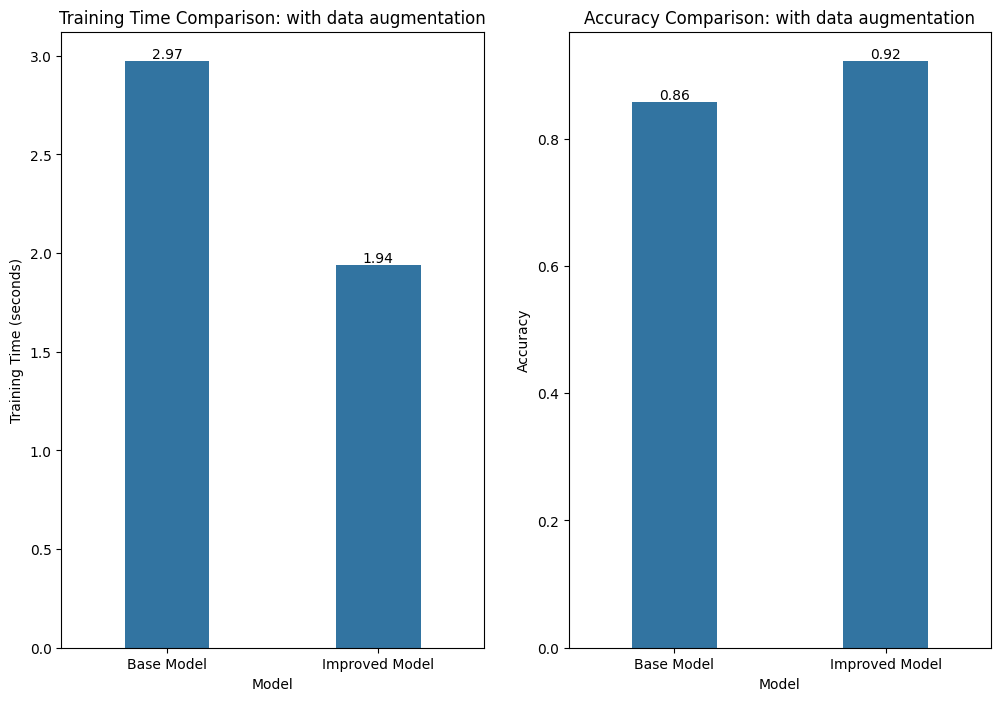

In [467]:
time_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Training Time (seconds)': [base_training_time, opt_4_time]
}

acc_data = {
    'Model': ['Base Model', 'Improved Model'],
    'Test Accuracy': [base_test_accuracy, opt_4_acc]
}

time_df = pd.DataFrame(time_data)
acc_df=pd.DataFrame(acc_data)

plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
bar_plot=sns.barplot(x='Model', y='Training Time (seconds)', data=time_df, width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Training Time Comparison: with data augmentation')
plt.xlabel('Model')
plt.ylabel('Training Time (seconds)')

plt.subplot(1,2,2)
#plt.figure(figsize=(3, 3))
bar_plot=sns.barplot(x='Model', y='Test Accuracy', data=acc_df,width=0.4)
for p in bar_plot.patches:
    bar_plot.annotate(f'{round(p.get_height(),2)}',
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.title('Accuracy Comparison: with data augmentation')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()


Based on the optimizations, the best model is the one built on top of base model with batch normalisation.

Building best model

In [470]:
#buildig the model, training, testing and saving the best model weights
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader=DataLoader(validation_dataset,batch_size=batch_size)
test_loader=DataLoader(test_dataset,batch_size=batch_size)
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork,self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device)
print(torchinfo.summary(model,input_size=(1,8)))

loss_function = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.0001)

start_time = time.time()
best_val_accuracy = 0.0  # Track the best validation accuracy
part2_model_weights = None
epochs=100
loss_t=[]
accuracy_t=[]
loss_val=[]
accuracy_val=[]
print(f"Learning rate: {rate}")
for epoch in range(epochs):
    #training phase
    model.train()
    total_batch_loss=0.0
    correct_predictions=0
    total_samples=0
    for X, Y in train_loader:

      outputs=model(X)
      #print(outputs)
      y_pred=outputs.squeeze()
      loss=loss_function(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_batch_loss+=loss.item()
      #print(loss.item())
      predictions = torch.round(y_pred)
      correct_predictions+=(predictions==Y).sum().item()
      total_samples+=Y.size(0)

    #training loss for the epoch
    avg_loss=total_batch_loss/len(train_loader)
    loss_t.append(avg_loss)
    #accuracy for the epoch
    accuracy=correct_predictions/total_samples
    accuracy_t.append(accuracy)
    model.eval()
    total_batch_loss_val=0.0
    correct_pred_val=0
    total_samples_val=0
    with torch.no_grad():
      for X_val,Y_val in validation_loader:
        outputs_val=model(X_val)
        y_pred_val=outputs_val.squeeze()
        val_loss=loss_function(y_pred_val,Y_val)
        total_batch_loss_val+=val_loss.item()
        pred_val=torch.round(y_pred_val)
        correct_pred_val+=(pred_val==Y_val).sum().item()
        total_samples_val+=Y_val.size(0)
    avg_loss_val=total_batch_loss_val/len(validation_loader)
    loss_val.append(avg_loss_val)
    acc_val=correct_pred_val/total_samples_val
    accuracy_val.append(acc_val)
    if acc_val > best_val_accuracy:
        best_val_accuracy = acc_val
        part2_model_weights = model.state_dict()


    if (epoch+1) % 10 ==0:
      print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.2f}, Val Loss: {avg_loss_val:.2f}")
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

torch.save(part2_model_weights, 'part_2.pt')
print(f"Best model saved with validation accuracy: {best_val_accuracy:.2f}")


model.load_state_dict(torch.load('part_2.pt'))
model.eval()
total_batch_loss_test=0
correct_pred_test=0
total_samples_test=0
loss_test=[]
accuracy_test=[]
pred=[]
actuals=[]
probabilities=[]
with torch.no_grad():
  for X_test_,Y_test_ in test_loader:
    output_test=model(X_test_)
    y_pred_test=output_test.squeeze()
    test_loss=loss_function(y_pred_test,Y_test_)
    total_batch_loss_test+=test_loss.item()
    pred_test=torch.round(y_pred_test)
    correct_pred_test+=(pred_test==Y_test_).sum().item()
    total_samples_test+=Y_test_.size(0)
    pred.extend(pred_test.numpy())
    actuals.extend(Y_test_.numpy())
    probabilities.extend(torch.sigmoid(y_pred_test).numpy())
avg_loss_test=total_batch_loss_test/len(test_loader)
acc_test=correct_pred_test/total_samples_test
loss_test=[avg_loss for i in range(epochs)]
accuracy_test=[acc_test for i in range(epochs)]

print(f"Test accuracy for best model:{round(acc_test,2)}")



Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            [1, 1]                    --
├─Flatten: 1-1                           [1, 8]                    --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─BatchNorm1d: 2-2                  [1, 32]                   64
│    └─ReLU: 2-3                         [1, 32]                   --
│    └─Dropout: 2-4                      [1, 32]                   --
│    └─Linear: 2-5                       [1, 16]                   528
│    └─BatchNorm1d: 2-6                  [1, 16]                   32
│    └─ReLU: 2-7                         [1, 16]                   --
│    └─Dropout: 2-8                      [1, 16]                   --
│    └─Linear: 2-9                       [1, 1]                    17
│    └─Sigmoid: 2-10                     [1, 1]                    --
Total params:

<ipython-input-470-335a425fd4db>:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('part_2.pt'))


In [471]:
#Evaluating performance on testing data. actuals and pred are lists populated at time of testing, in above cell
accuracy = accuracy_score(actuals, pred)
precision = precision_score(actuals, pred)
recall = recall_score(actuals, pred)
f1 = f1_score(actuals, pred)

print(f"Accuracy using pytorch method: {round(accuracy,2)}")
print(f"Precision using pytorch method: {round(precision,2)}")
print(f"Recall using pytorch method: {round(recall,2)}")
print(f"f1 score using pytorch method: {round(f1,2)}")

Accuracy using pytorch method: 0.99
Precision using pytorch method: 1.0
Recall using pytorch method: 0.98
f1 score using pytorch method: 0.99


### Visualisations

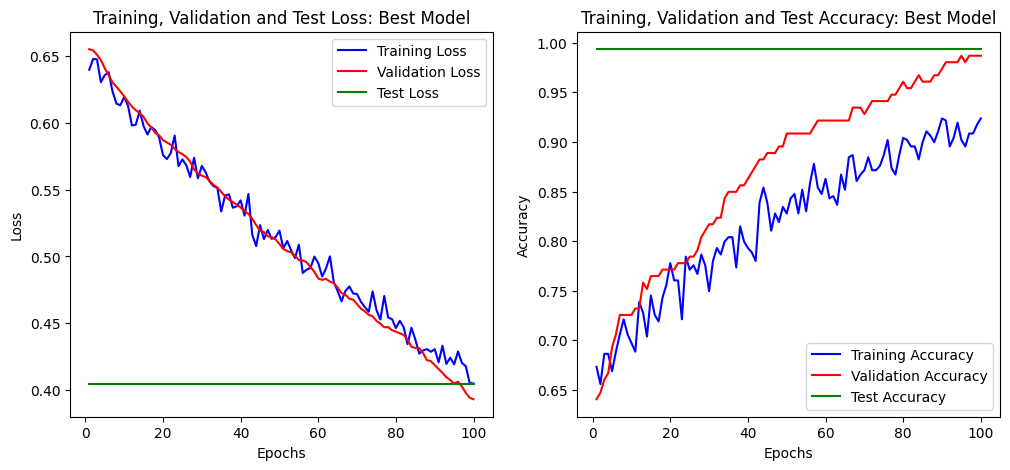

In [472]:
#Loss graph and accuracy graph for train, validation and test data over 100 epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(loss_t) + 1), loss_t, 'b', label='Training Loss')
plt.plot(range(1, len(loss_val) + 1), loss_val, 'r', label='Validation Loss')
plt.plot(range(1, len(loss_test) + 1),loss_test,color='green',label="Test Loss")
plt.title('Training, Validation and Test Loss: Best Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1, len(accuracy_t) + 1), accuracy_t, 'b', label='Training Accuracy')
plt.plot(range(1, len(accuracy_val) + 1), accuracy_val, 'r', label='Validation Accuracy')
plt.plot(range(1, len(accuracy_test) + 1),accuracy_test,color='green',label="Test Accuracy")
plt.title('Training, Validation and Test Accuracy: Best Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


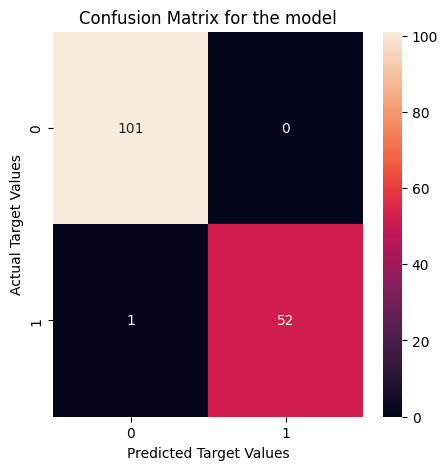

In [473]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(np.array(actuals),np.array(pred))
plt.figure(figsize=(5,5))
sns.heatmap(cm,annot=True,xticklabels=['0', '1'], yticklabels=['0', '1'],fmt='d')
plt.xlabel('Predicted Target Values')
plt.ylabel('Actual Target Values')
plt.title('Confusion Matrix for the model')
plt.show()


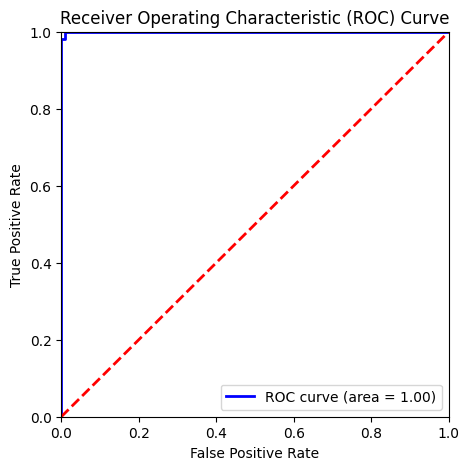

In [474]:

#ROC curve
fpr, tpr, thresholds = roc_curve(np.array(actuals), np.array(probabilities))
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()